# Deep Atrous Guided Filter Demo


In [1]:
# install requirements
!pip install -r requirements.txt

  Cloning https://github.com/S-aiueo32/contextual_loss_pytorch.git to /tmp/pip-req-build-wo3r6bns
  Running command git clone -q https://github.com/S-aiueo32/contextual_loss_pytorch.git /tmp/pip-req-build-wo3r6bns
  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-bh4l5rm_
  Running command git clone -q https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-bh4l5rm_
  Running command git submodule update --init --recursive -q
  Created wheel for contextual-loss-pytorch: filename=contextual_loss_pytorch-latest-py3-none-any.whl size=7323 sha256=b7618c8f5b81268713a1935f14bf6b12f6e49d01c66cfc152ab2da5df12a2629
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kduyo_d/wheels/6c/63/07/daab99bc0ea80c6e1b69c873d2a470b0c116f4fcdf58cc1ace
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4965 sha256=98dc8ffa5a7b4772dc00b3d0333170f0aede51f756a7a2b2ad46430bdeac23f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kduyo_

In [2]:
# Imports
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path
import os
import warnings
warnings.simplefilter("ignore")

In [3]:
args = {
    "image_dir": Path("data"),
    "ckpt_dir": Path("ckpts"),
    "pixelshuffle_ratio": 2,
    "guided_map_kernel_size": 3,
    "guided_map_channels": 16,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu"
}


# Convert dictionary to object notation
class Tupperware(object):
    def __init__(self, entries):
        self.__dict__.update(entries)
        
args = Tupperware(args)

In [4]:
# download pre-trained weights for POLED and TOLED
if not args.ckpt_dir.exists():
    os.mkdir(args.ckpt_dir)
    
poled_path = str(args.ckpt_dir / 'poled_final.pth')
toled_path = str(args.ckpt_dir / 'toled_final.pth')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r' -O {poled_path}
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Fmub65AsMK231czImqsZWprxDCNx21AA' -O {toled_path}

--2020-08-07 17:45:14--  https://docs.google.com/uc?export=download&id=1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r
Resolving docs.google.com (docs.google.com)... 172.217.31.206, 2404:6800:4007:809::200e
Connecting to docs.google.com (docs.google.com)|172.217.31.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hr89rsilocukmlkro9u3vt7vacue2c1s/1596802500000/05935635026363679465/*/1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r?e=download [following]
--2020-08-07 17:45:15--  https://doc-08-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hr89rsilocukmlkro9u3vt7vacue2c1s/1596802500000/05935635026363679465/*/1F_5ddx4ooIwFKFc4ewpb_CPUVCcUN25r?e=download
Resolving doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googleusercontent.com)... 172.217.163.65, 2404:6800:4007:80c::2001
Connecting to doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googl

## DAGF Overview
Our model restores an image in two-stages : A low-resolution network (LRNet) first restores the image at a lower resolution, which is subsequently used by the Guided Filter Network as a filtering input to produce a high-resolution output.
<img src="figs/fig_2.png">

In [5]:
from models.guided_filter import DeepAtrousGuidedFilter
from utils.model_serialization import load_state_dict
device = args.device
model = DeepAtrousGuidedFilter(args).to(device)
model.eval()

DeepAtrousGuidedFilter(
  (guided_map): SmoothDilatedResidualAtrousGuidedBlock(
    (norm1): AdaptiveInstanceNorm(
      (ins_norm): InstanceNorm2d(8, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
    )
    (norm2): AdaptiveInstanceNorm(
      (ins_norm): InstanceNorm2d(8, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
    )
    (norm4): AdaptiveInstanceNorm(
      (ins_norm): InstanceNorm2d(8, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
    )
    (norm8): AdaptiveInstanceNorm(
      (ins_norm): InstanceNorm2d(8, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
    )
    (pre_conv1): ShareSepConv()
    (pre_conv2): ShareSepConv()
    (pre_conv4): ShareSepConv()
    (pre_conv8): ShareSepConv()
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (conv4): Conv2d(3

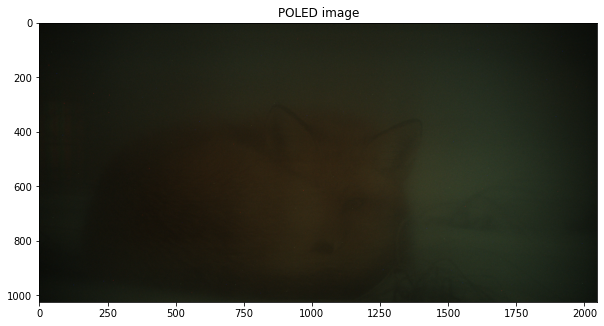

In [6]:
# Poled demo
poled_img_path = args.image_dir / "ex_poled.png"
poled_img = cv2.imread(str(poled_img_path))[:,:,::-1]/255

# visualise image
plt.figure(figsize=(10, 20))
plt.imshow(poled_img)
plt.title('POLED image')
# preprocessing
poled_img = torch.Tensor(poled_img.copy()).permute(2, 0, 1).unsqueeze(0)
poled_img = poled_img.mul(2).sub(1) 

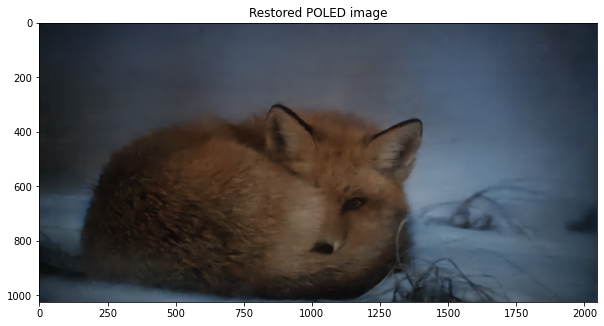

In [7]:
# load pre-trained weights
ckpt = torch.load(poled_path, map_location=torch.device(device))
load_state_dict(model, ckpt['state_dict'])

with torch.no_grad():
    poled_out = model(poled_img.to(device))[0].cpu().permute(1,2,0).numpy()
poled_out = (poled_out + 1)/2
plt.figure(figsize=(10, 20))
plt.imshow(poled_out)
plt.title('Restored POLED image')
plt.show()

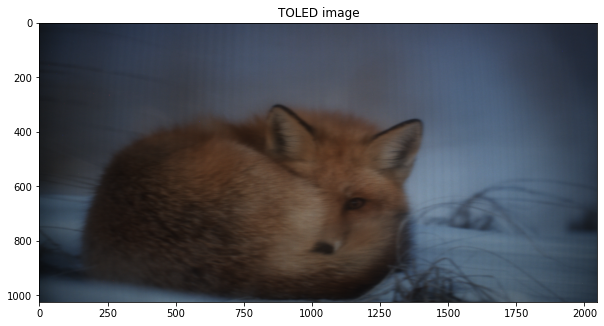

In [8]:
# Toled demo

toled_img_path = args.image_dir / "ex_toled.png"
toled_img = cv2.imread(str(toled_img_path))[:,:,::-1]/255

# visualise image
plt.figure(figsize=(10, 20))
plt.imshow(toled_img)
plt.title('TOLED image')

# preprocessing
toled_img = torch.Tensor(toled_img.copy()).permute(2, 0, 1).unsqueeze(0)
toled_img = toled_img.mul(2).sub(1) 

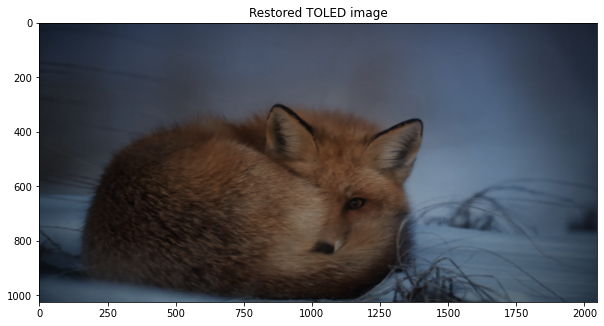

In [9]:
# load pre-trained weights
ckpt = torch.load(toled_path, map_location=torch.device(device))
load_state_dict(model, ckpt['state_dict'])

with torch.no_grad():
    toled_out = model(toled_img.to(device))[0].cpu().permute(1,2,0).numpy()
toled_out = (toled_out + 1)/2
plt.figure(figsize=(10, 20))
plt.imshow(toled_out)
plt.title('Restored TOLED image')
plt.show()